# Проект: классификация

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from  sklearn.ensemble import IsolationForest
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing  import LabelEncoder
from sklearn import linear_model 
from sklearn import tree 
from sklearn import ensemble 
from sklearn import metrics 
from sklearn import preprocessing 
from sklearn.model_selection import train_test_split 
from sklearn.feature_selection import SelectKBest, f_classif

## Часть 1. Знакомство с данными, обработка пропусков и выбросов

### Задание 1

In [2]:
df = pd.read_csv('data/bank_fin.zip', sep = ';')
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,59,admin.,married,secondary,no,"2 343,00 $",yes,no,unknown,5,may,1042,1,-1,0,unknown,yes
1,56,admin.,married,secondary,no,"45,00 $",no,no,unknown,5,may,1467,1,-1,0,unknown,yes
2,41,technician,married,secondary,no,"1 270,00 $",yes,no,unknown,5,may,1389,1,-1,0,unknown,yes
3,55,services,married,secondary,no,"2 476,00 $",yes,no,unknown,5,may,579,1,-1,0,unknown,yes
4,54,admin.,married,tertiary,no,"184,00 $",no,no,unknown,5,may,673,2,-1,0,unknown,yes


Данные о клиентах банка:

* `age` (возраст);
* `job` (сфера занятости);
* `marital` (семейное положение);
* `education` (уровень образования);
* `default` (имеется ли просроченный кредит);
* `housing` (имеется ли кредит на жильё);
* `loan` (имеется ли кредит на личные нужды);
* `balance` (баланс).

Данные, связанные с последним контактом в контексте текущей маркетинговой кампании:

* `contact` (тип контакта с клиентом);
* `month` (месяц, в котором был последний контакт);
* `day` (день, в который был последний контакт);
* `duration` (продолжительность контакта в секундах).

Прочие признаки:

* `campaign` (количество контактов с этим клиентом в течение текущей кампании);
* `pdays` (количество пропущенных дней с момента последней маркетинговой кампании до контакта в текущей кампании);
* `previous` (количество контактов до текущей кампании)
* `poutcome` (результат прошлой маркетинговой кампании).

И, разумеется, наша целевая переменная `deposit`, которая определяет, согласится ли клиент открыть депозит в банке. Именно её мы будем пытаться предсказать в данном кейсе.

Начнём с того, что оценим, насколько предложенные данные готовы к дальнейшему анализу. В первую очередь давайте выясним, есть ли в данных пропущенные значения (пустые, незаполненные ячейки).

In [3]:
# исследуйте данные на предмет пропусков. Где есть пропущенные значения? Сколько их?
# ваш код
df.isna().sum()

age           0
job           0
marital       0
education     0
default       0
balance      25
housing       0
loan          0
contact       0
day           0
month         0
duration      0
campaign      0
pdays         0
previous      0
poutcome      0
deposit       0
dtype: int64

### Задание 2

Видим отсутствующие значения в признаке `balance`. 
Исследуем остальные признаки.

In [4]:
# есть ли в признаке job пропущенные значения? Возможно, они обозначены каким-то специальным словом?
# ваш код
for column in df.columns:
    print(f'value counts for {column}')
    print(df[column].value_counts())
    print()

value counts for age
31    496
32    477
34    466
33    464
35    461
     ... 
92      2
93      2
88      2
95      1
89      1
Name: age, Length: 76, dtype: int64

value counts for job
management       2566
blue-collar      1944
technician       1823
admin.           1334
services          923
retired           778
self-employed     405
student           360
unemployed        357
entrepreneur      328
housemaid         274
unknown            70
Name: job, dtype: int64

value counts for marital
married     6351
single      3518
divorced    1293
Name: marital, dtype: int64

value counts for education
secondary    5476
tertiary     3689
primary      1500
unknown       497
Name: education, dtype: int64

value counts for default
no     10994
yes      168
Name: default, dtype: int64

value counts for balance
0  $            774
 1,00 $          39
 3,00 $          34
 2,00 $          34
 4,00 $          29
               ... 
 1 641,00 $       1
 5 517,00 $       1
 8 332,00 $       1
 4

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11162 entries, 0 to 11161
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        11162 non-null  int64 
 1   job        11162 non-null  object
 2   marital    11162 non-null  object
 3   education  11162 non-null  object
 4   default    11162 non-null  object
 5   balance    11137 non-null  object
 6   housing    11162 non-null  object
 7   loan       11162 non-null  object
 8   contact    11162 non-null  object
 9   day        11162 non-null  int64 
 10  month      11162 non-null  object
 11  duration   11162 non-null  int64 
 12  campaign   11162 non-null  int64 
 13  pdays      11162 non-null  int64 
 14  previous   11162 non-null  int64 
 15  poutcome   11162 non-null  object
 16  deposit    11162 non-null  object
dtypes: int64(6), object(11)
memory usage: 1.4+ MB


После анализа вариантов значений в наших данных выявили дополнительные отсутствующие значения, которые закодированы словом unknown. Значения были выявлены в следующих признаках:
* `job` – 70 шт
* `education` – 497 шт
* `contact` – 2346 шт
* `poutcome` – 8326 шт

При этом общее количество признаков равно `11162` шт.

Не во всех признаках значение `unknown` следует считать пропуском и как-то обрабатывать. Например, для признака `poutcome` (результат прошлой маркетинговой кампании) большинство значений заполнены `unknown`. Возможно этот клиент не участвовал в предыдущей кампании. Требуется дополнительное исследование.

### Задание 3

Обработаем признак `balance`: в данных содержится лишняя запятая и знак доллара. По этой причине этот признак не считывается как число. Обработаем данные этого признака так, чтобы он был преобразован в тип float.

In [6]:
# преобразуйте признак balance таким образом, чтобы он корректно считывался, как вещественное число (float)
df['balance'] = df['balance'].map(lambda x: x.strip().replace(' ','').replace('$','').replace(',','.'), na_action='ignore')
df['balance'] = df['balance'].astype('float')
df['balance'].describe()

count    11137.000000
mean      1529.129029
std       3228.114892
min      -6847.000000
25%        123.000000
50%        550.000000
75%       1708.000000
max      81204.000000
Name: balance, dtype: float64

### Задание 4

Итак, значения в признаке balance приобрели нормальный вид, и теперь мы можем обработать пропуски, которые в нём присутствуют. Конечно, пропуски можно было бы просто удалить, но мы поступим по-другому: заменим пропуски на медианное значение по этому признаку.

In [7]:
# обработайте пропуски в признаки balance , заменив их на медианные значения по данному признаку
# ваш код
df.fillna(df['balance'].median(), inplace=True)
round(df['balance'].mean(), 3)

1526.936

### Задание 5

Ранее мы выяснили, что в признаке `job` есть пропущенные значения, которые не отображаются как пропуски в явном виде. Однако нам всё равно важно их обработать. Мы знаем, что для категориальных признаков пропущенные значения заменяются модой по данному признаку.

Заменим пропущенные значения в признаках `job` и `education` на модальные. 

In [8]:
# обработайте пропуски в категориальных признаках: job и education, заменив их на модальные значения
# ваш код
df['job'].replace('unknown', df['job'].mode()[0], inplace=True)
# проверяем корректное заполнение
df['job'].value_counts() 


management       2636
blue-collar      1944
technician       1823
admin.           1334
services          923
retired           778
self-employed     405
student           360
unemployed        357
entrepreneur      328
housemaid         274
Name: job, dtype: int64

In [9]:
df['education'].replace('unknown', df['education'].mode()[0], inplace=True)
# проверяем корректное заполнение
df['education'].value_counts() 

secondary    5973
tertiary     3689
primary      1500
Name: education, dtype: int64

#### Задание 2.5

После замены пропусков рассчитайте средний баланс для клиентов с самой популярной работой и самым популярным уровнем образования (т. е. для тех, у кого одновременно самая популярная работа и самое популярное образование). Ответ округлите до трёх знаков после точки-разделителя.

In [10]:
round(df[ (df['job'] == df['job'].mode()[0]) & (df['education'] == df['education'].mode()[0]) ]['balance'].mean(), 3)

1598.883

### Задание 6

Изучаем признак `balance` на предмет выбросов.
В базовом варианте будем использовать метод Тьюки: считаем, что выбросы находятся за пределами отрезка, нижняя граница которого определяется как нижний квартиль, из которого вычли полтора межквартильных размаха, а верхняя граница — как верхний квартиль, к которому прибавили полтора межквартильных размаха.

In [11]:
# удалите все выбросы для признака balance
# ваш код
q1, q3 = df['balance'].quantile([.25, .75]) # нижний и верхний квартили
iqr = q3 - q1 # межквартильный размах
upper_border = q3 + 1.5*iqr
lower_border = q1 - 1.5*iqr
print(lower_border,upper_border)

-2241.0 4063.0


Нижнюю и верхнюю границу по методу Тьюки определили, осталось удалить все строки, в которых `balance` выходит за эти границы.

In [12]:
print(f'df shape before delete: {df.shape}')
balance_outliers_index = df[ (df['balance'] < lower_border) | (df['balance'] > upper_border)].index
df.drop(balance_outliers_index, inplace=True)
print(f'df shape after delete:  {df.shape}')


df shape before delete: (11162, 17)
df shape after delete:  (10105, 17)


## Часть 2:  Разведывательный анализ

### Задание 1

Соотношение классов целевого признака deposit: 
no     53.676398
yes    46.323602
Name: deposit, dtype: float64


<Axes: xlabel='deposit', ylabel='count'>

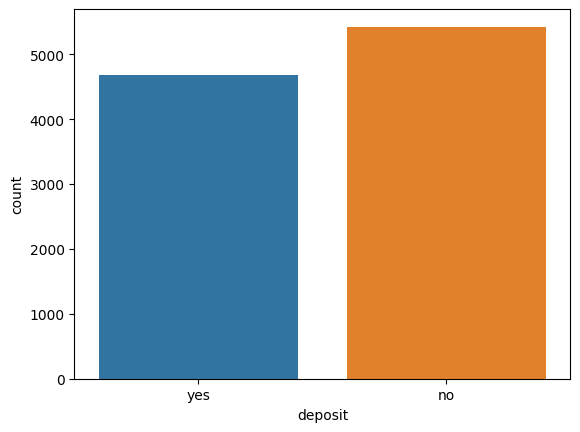

In [13]:
# изучите соотношение классов в ваших данных на предмет несбалансированности, проиллюстрируйте результат
# ваш код
print('Соотношение классов целевого признака deposit: \n', df.deposit.value_counts(normalize=True)*100, sep='')
sns.countplot(df, x='deposit')

Видим, что соотношение классов целевой характеристики 46 к 54. Можно сказать, что классы сбалансированны, дополнительные действия не требуются.

### Задания 2 и 3

In [14]:
#рассчитайте описательные статистики для количественных переменных, проинтерпретируйте результат
#ваш код
df.describe()

,age,balance,day,duration,campaign,pdays,previous
count,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000
mean,40.895497,807.653538,15.590302,368.742603,2.517170,51.319644,0.816230
std,11.734931,994.151966,8.441510,346.651524,2.707159,109.644179,2.243795
min,18.000000,-2049.000000,1.000000,2.000000,1.000000,-1.000000,0.000000
25%,32.000000,95.000000,8.000000,137.000000,1.000000,-1.000000,0.000000
50%,38.000000,445.000000,15.000000,252.000000,2.000000,-1.000000,0.000000
75%,48.000000,1227.000000,22.000000,490.000000,3.000000,2.000000,1.000000
max,95.000000,4063.000000,31.000000,3881.000000,43.000000,854.000000,58.000000


Выделим все количественные переменные в отдельный список:

In [15]:
df_types = df.dtypes
q_features = list(df_types[df_types != 'object'].index)
q_features

['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous']

In [18]:
ax_hist.xaxis.get_tick_params()

{'left': True,
 'right': False,
 'labelleft': True,
 'labelright': False,
 'gridOn': False}

In [19]:
ax_box.xaxis.get_tick_params()

{'left': True,
 'right': False,
 'labelleft': False,
 'labelright': False,
 'gridOn': False}

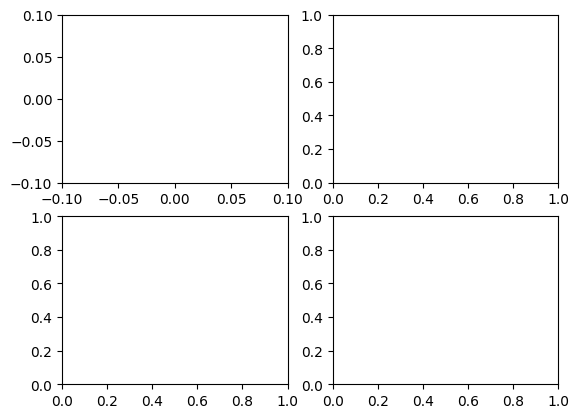

In [32]:
ax1 = plt.subplot(221)
ax1.margins(.5)
ax2 = plt.subplot(222)
ax3 = plt.subplot(223)
ax4 = plt.subplot(224)

plt.show()

In [49]:
fig = plt.figure(layout="constrained")
subfigs = fig.subfigures(1, 2, wspace=0.07, width_ratios=[1.5, 1.])
axs0 = subfigs[0].subplots(2, 2)
subfigs[0].set_facecolor('0.9')
subfigs[0].suptitle('subfigs[0]\nLeft side')
subfigs[0].supxlabel('xlabel for subfigs[0]')

axs1 = subfigs[1].subplots(3, 1)
subfigs[1].suptitle('subfigs[1]')
# subfigs[1].supylabel('ylabel for subfigs[1]')

In [70]:
nrows = round(len(q_features)/2)

fig = plt.figure(layout='constrained', figsize=[155, 10])
subfigs = fig.subfigures(nrows=len(q_features), ncols=1, wspace=0.07)

(ax_box, ax_hist) = subfigs[0].subplots(2, 1)
sns.boxplot(df['age'], orient='h', ax=ax_box)
sns.histplot(data=df, x='age', ax=ax_hist)

(ax_box1, ax_hist1) = subfigs[1].subplots(2, 1)
sns.boxplot(df['balance'], orient='h', ax=ax_box1)
sns.histplot(data=df, x='balance', ax=ax_hist1)

<Axes: xlabel='balance', ylabel='Count'>

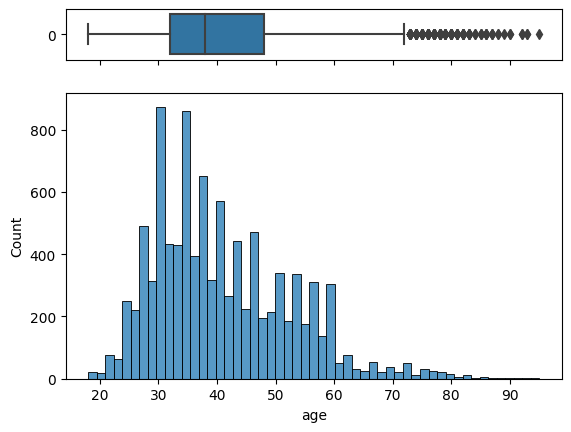

In [22]:
fig, (ax_box, ax_hist) = plt.subplots(nrows=2, sharex=True, gridspec_kw={'height_ratios': (.15, .85)})

sns.boxplot(df['age'], orient='h', ax=ax_box)
sns.histplot(data=df, x='age', ax=ax_hist)

plt.show()

<Axes: xlabel='age', ylabel='Count'>

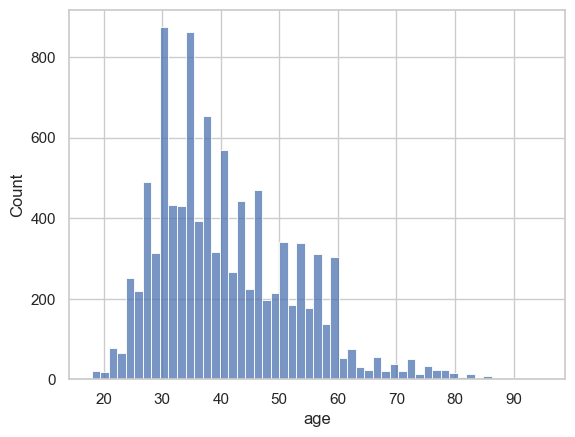

In [ ]:
sns.histplot(df['age'])

In [ ]:
sns.pairplot(df, hue='deposit')

### Задания 4 и 5

In [ ]:
#рассчитайте описательные статистики для категориальных переменных, проинтерпретируйте результат
#ваш код
#постройте визуализации, иллюстрирующие результаты
df.describe(include=[object])

,job,marital,education,default,housing,loan,contact,month,poutcome,deposit
count,10105,10105,10105,10105,10105,10105,10105,10105,10105,10105
unique,11,3,3,2,2,2,3,12,4,2
top,management,married,secondary,no,no,no,cellular,may,unknown,no
freq,2315,5715,5517,9939,5243,8712,7283,2617,7570,5424


In [ ]:
df_types = df.dtypes
cat_features = list(df_types[df_types == 'object'].index)
cat_features

['job',
 'marital',
 'education',
 'default',
 'housing',
 'loan',
 'contact',
 'month',
 'poutcome',
 'deposit']

### Задание 6

In [ ]:
# Узнайте, для какого статуса предыдущей маркетинговой кампании успех в текущей превалирует над количеством неудач.
# ваш код

### Задание 7

In [ ]:
# узнайте, в каком месяце чаще всего отказывались от предложения открыть депозит
# ваш код

### Задание 8

In [ ]:
# создайте возрастные группы и определите, в каких группах более склонны открывать депозит, чем отказываться от предложения

### Задания 9 и 10

In [ ]:
# постройте визуализации для открывших и неоткрывших депозит в зависимости от семейного статуса

In [ ]:
# постройте визуализации для открывших и неоткрывших депозит в зависимости от образования

In [ ]:
# постройте визуализации для открывших и неоткрывших депозит в зависимости от вида профессиональной занятости

### Задание 11

In [ ]:
# постройте сводную таблицу, чтобы определить люди с каким образованием и семейным статусом наиболее многочисленны
#(если рассматривать тех, кто открыл депозит)

## Часть 3: преобразование данных

### Задание 1

In [ ]:
# преобразуйте уровни образования

### Задания 2 и 3

In [ ]:
# преобразуйте бинарные переменные в представление из нулей и единиц

### Задание 4

In [ ]:
# создайте дамми-переменные

### Задания 5 и 6

In [ ]:
# постройте корреляционную матрицу и оцените данные на предмет наличия мультиколлинеарности

### Задания 7 и 8

In [ ]:
X = df.drop(['deposit'], axis=1)
y = df['deposit']
 
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state = 42, test_size = 0.33)

In [ ]:
# рассчитайте необходимые показатели

### Задание 9

In [ ]:
# с помощью SelectKBest отберите 15 наиболее подходящих признаков

### Задание 10

In [ ]:
# нормализуйте данные с помощью minmaxsxaler

# Часть 4: Решение задачи классификации: логистическая регрессия и решающие деревья

### Задание 1

In [ ]:
# обучите логистическую регрессию и рассчитайте метрики качества

### Задания 2,3,4

In [ ]:
# обучите решающие деревья, настройте максимальную глубину

### Задание 5

In [ ]:
# подберите оптимальные параметры с помощью gridsearch

# Часть 5: Решение задачи классификации: ансамбли моделей и построение прогноза

### Задание 1

In [ ]:
# обучите на ваших данных случайный лес

### Задания 2 и 3

In [ ]:
# используйте для классификации градиентный бустинг и сравните качество со случайным лесом

### Задание 4

In [ ]:
# объедините уже известные вам алгоритмы с помощью стекинга 

### Задание 5

In [ ]:
# оцените, какие признаки демонстрируют наибольшую  важность в модели градиентного бустинга

### Задания 6,7,8

In [ ]:
# реализуйте оптимизацию гиперпараметров с помощью Optuna